<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bias-Studies" data-toc-modified-id="Bias-Studies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bias Studies</a></span></li></ul></div>

# Evaluating Model Params using Slurm configs

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import time
import copy
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import OrderedDict

import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from lmfit.models import LinearModel

%aimport mre 
from mre import pytorch_arch
%aimport mre.mre_datasets
from mre.mre_datasets import MRETorchDataset, MREtoXr, ModelCompare, ModelComparePandas
%aimport mre.plotting
from mre.plotting import hv_dl_vis, hv_pred_comp, xr_viewer_v2, miccai_plots, xr_viewer_models, roc_curves
%aimport mre.train_mre_model
from mre.train_mre_model import train_model_full
%aimport mre.prediction
from mre.prediction import add_predictions, get_linear_fit, add_val_linear_cor

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import hvplot.pandas


KeyboardInterrupt: 

In [ ]:
base_model_path = '/pghbio/dbmi/batmanlab/Data/MRE/XR_full_gold_clinical_v3/*.nc'
pred_path = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/'
# pred_dict = OrderedDict((
#     ('baseline', pred_path+'2020-03-24_23-10-35_n0/test/*.nc'),
#     ('three_best', pred_path+'2020-03-26_21-57-02_n0/test/*.nc'),
#     ('three_nocon', pred_path+'2020-03-27_10-59-38_n0/test/*.nc')))
# ds_models = ModelCompare(pred_dict=pred_dict).ds

# pred_dict = OrderedDict((
#     # ('baseline', pred_path+'2020-04-10_10-31-02_n0/test/*.nc'),
#     #('baseline', pred_path+'2020-04-17_10-56-32_n0/test/*.nc'),
#     #('baseline_3best', pred_path+'2020-04-14_14-30-32_n0/test/*.nc'),
#     # ('clinical', pred_path+'2020-04-10_20-59-57_n0/test/*.nc'),
#     #('clinical', pred_path+'2020-04-17_10-56-32_n1/test/*.nc'),
#     ('clinical_3best_erode1', pred_path+'2020-04-22_13-02-52_n0/test/*.nc'),
#     ('clinical_3best_erode2', pred_path+'2020-04-23_00-17-40_n0/test/*.nc'),
#     ('clinical_3best_erode3', pred_path+'2020-04-15_10-55-56_n0/test/*.nc'),
#     ('clinical_3best_erode4', pred_path+'2020-04-23_00-17-40_n1/test/*.nc'),
#     ('clinical_3best_erode5', pred_path+'2020-04-23_00-17-40_n2/test/*.nc'),
#     #('clinical_3best_smear2', pred_path+'2020-04-16_22-00-43_n0/test/*.nc'),
#     #('clinical_3best_smear3', pred_path+'2020-04-16_14-20-43_n0/test/*.nc'),
#     #('clinical_3best_smear5', pred_path+'2020-04-16_22-02-12_n0/test/*.nc')))
#     # ('baseline_erode', pred_path+'2020-04-13_09-45-21_n0/test/*.nc'),
#     # ('clinical_erode', pred_path+'2020-04-11_16-59-40_n0/test/*.nc'),
#     # ('baseline_erode_pix', pred_path+'2020-04-13_09-45-21_n0/test/*.nc')))
#     # ('clinical_erode', pred_path+'2020-04-12_12-26-32_n0/test/*.nc')))
# ))
pred_dict = OrderedDict((
    ('clinical_3best_erode3', pred_path+'2020-04-15_10-55-56_n0/test/*.nc'),
    ('rand_seed_n0', pred_path+'2020-04-24_10-35-46_n0/test/*.nc'),
    ('rand_seed_n1', pred_path+'2020-04-24_10-35-46_n1/test/*.nc'),
    ('rand_seed_n2', pred_path+'2020-04-24_10-35-46_n2/test/*.nc'),
    #('rand_seed_n3', pred_path+'2020-04-24_10-35-46_n3/test/*.nc'),
    # ('rand_seed_n4', pred_path+'2020-04-24_10-35-46_n4/test/*.nc'),
    ('rand_seed_n5', pred_path+'2020-04-24_10-35-46_n5/test/*.nc'),
    #('rand_seed_n6', pred_path+'2020-04-24_10-35-46_n6/test/*.nc'),
    ('rand_seed_n7', pred_path+'2020-04-24_10-35-46_n7/test/*.nc'),
    ('rand_seed_n8', pred_path+'2020-04-24_10-35-46_n8/test/*.nc'),
    ('rand_seed_n9', pred_path+'2020-04-24_10-35-46_n9/test/*.nc'),
))
ds_models = ModelCompare(base_model_path=base_model_path, pred_dict=pred_dict).ds

In [3]:
ds_models

<xarray.Dataset>
Dimensions:         (mask_type: 3, mre_type: 12, sequence: 9, subject: 149, x: 256, y: 256, z: 32, z_idx: 4)
Coordinates:
  * subject         (subject) object '0006' '0020' '0029' ... '2034' '2046'
  * sequence        (sequence) object 't1_pre_water' ... 't1_pos_300_water'
  * mask_type       (mask_type) object 'liver' 'mre' 'combo'
  * mre_type        (mre_type) <U21 'mre' 'mre_mask' ... 'rand_seed_n9'
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * y               (y) int64 255 254 253 252 251 250 249 248 ... 6 5 4 3 2 1 0
  * z               (z) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: z_idx
Data variables:
    image_mri       (subject, sequence, x, y, z) int16 0 0 0 0 0 0 ... 0 0 0 0 0
    mask_mri        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    image_mre       (subject, mre_type, x, y, z) float64 0.0 0.0 ... 316.0 362.0
    mask_mre        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    mri_to_mre_idx  (subject, z_idx) int16 18 20 22 24 19 21 ... 20 16 18 20 22
    val_slope       (subject, mre_type) float64 1.0 1.0 1.0 ... 0.5793 0.5028
    val_intercept   (subject, mre_type) float64 0.0 0.0 ... 1.863e+03 2.243e+03

In [4]:
df = ModelComparePandas(ds_models, do_cor=True, do_aug=False).df
df.index.name='subject'

In [5]:
df

mre  clinical_3best_erode3  rand_seed_n0  rand_seed_n1  \
subject                                                                   
0006     3965.567046            5013.180653   3155.704341   7921.283193   
0020     3727.600644            3135.828782   2819.529906   3755.252654   
0029     3727.600644            2638.362697   3464.947001   5533.665418   
0043     3485.988186            1775.108316   2436.289913   3150.117867   
0126     5513.681652            9552.269535   4698.893340   6829.878687   
...              ...                    ...           ...           ...   
2001     7220.789339           10448.632270   9297.004527   6210.793889   
2007     5780.700864            6636.910897   4796.110084   7300.192983   
2029     2261.857323            1516.708113   3276.686551   1892.353775   
2034     2623.089670            3860.406906   3603.046407   2867.131403   
2046     6641.576844            4671.491511   3689.930713   5853.456037   

         rand_seed_n2  rand_seed_n5  rand_seed_n7  rand_seed_n8  rand_seed_n9  
subject                                                                        
0006      7195.162029   4731.316218   4247.296259   6365.311095   5236.343557  
0020      2653.590836   3479.608134   4354.023692   2789.975361   2642.680587  
0029      6342.263028   3107.755710   3873.519345   3269.356414   3775.456460  
0043      3347.724406   3039.168376   2031.073960   5120.087854   3310.710118  
0126      7156.231609   8097.308013   6995.129233   5383.438005   6203.225234  
...               ...           ...           ...           ...           ...  
2001      9810.207233  10015.401423   9888.760824  12469.461859   8912.068968  
2007      5415.599212   8168.400644   5638.904840   6822.816346   5527.279670  
2029      1799.907697   2108.070902   1431.649702   2338.354533   1433.247165  
2034      2985.031028   4626.544347   3840.919286   3707.640556   2886.694261  
2046      2538.462908   3492.343839   3555.223073   5979.037028   3867.349232  

[149 rows x 9 columns]

In [1]:
# for thresh in [2.88, 3.54, 3.77, 4.09]:
#     plt.figure()
#     roc_curves(df, pred='baseline', label='9 Inputs', threshold=thresh)
#     roc_curves(df, pred='three_best', label='3 Inputs, Best', threshold=thresh)
#     roc_curves(df, pred='three_nocon', label='3 Inputs, No Contrast', threshold=thresh)
for thresh in [2.88, 3.54, 3.77, 4.09]:
    df_ave_num = [['sens', 'spec', 'acc', 'auroc']]
    plt.figure()
    #roc_curves(df, pred='baseline', label='9 Inputs', threshold=thresh)
    #roc_curves(df, pred='baseline_3best', label='3 Inputs', threshold=thresh)
    #roc_curves(df, pred='clinical', label='9 Inputs, Clinical Features', threshold=thresh)
    # roc_curves(df, pred='clinical_3best_erode1', label='3 Inputs, Clinical Features, Erode 1', threshold=thresh)
    # roc_curves(df, pred='clinical_3best_erode2', label='3 Inputs, Clinical Features, Erode 2', threshold=thresh)
    df_ave_num.append(roc_curves(df, pred='clinical_3best_erode3', label='3 Inputs, Clinical Features, Erode 3', threshold=thresh))
    # roc_curves(df, pred='clinical_3best_erode4', label='3 Inputs, Clinical Features, Erode 4', threshold=thresh)
    # roc_curves(df, pred='clinical_3best_erode5', label='3 Inputs, Clinical Features, Erode 5', threshold=thresh)
    #roc_curves(df, pred='clinical_3best_smear2', label='3 Inputs, Clinical Features, Smear 2', threshold=thresh)
    #roc_curves(df, pred='clinical_3best_smear3', label='3 Inputs, Clinical Features, Smear 3', threshold=thresh)
    #roc_curves(df, pred='clinical_3best_smear5', label='3 Inputs, Clinical Features, Smear 5', threshold=thresh)
    
    df_ave_num.append(roc_curves(df, pred='rand_seed_n0', label='rand_seed_n0', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n1', label='rand_seed_n1', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n2', label='rand_seed_n2', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n5', label='rand_seed_n5', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n7', label='rand_seed_n7', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n8', label='rand_seed_n8', threshold=thresh))
    df_ave_num.append(roc_curves(df, pred='rand_seed_n9', label='rand_seed_n9', threshold=thresh))
    print(df_ave_num)

NameError: name 'plt' is not defined

In [10]:
pd.set_option('display.max_columns', None)
df_clinical = pd.read_excel('../data/MRE/MRE_dataset_clinical.xlsx')
df_clinical.describe()

Accession Numbers         Age  Gender (M=0, F=1)  \
count       1.670000e+02  167.000000         167.000000   
mean        8.557218e+07   57.281437           0.497006   
std         3.279334e+06   12.040037           0.501495   
min         7.389018e+07   18.000000           0.000000   
25%         8.379660e+07   51.000000           0.000000   
50%         8.637511e+07   60.000000           0.000000   
75%         8.811387e+07   66.000000           1.000000   
max         9.124523e+07   79.000000           1.000000   

       Race (White=0, Black=1, Hispanic=2, Other=3)  Height (cm)  Weight (kg)  \
count                                    135.000000   165.000000   165.000000   
mean                                       0.081481   168.819030    89.842642   
std                                        0.457962    10.668982    16.719571   
min                                        0.000000   145.000000    54.100000   
25%                                        0.000000   160.000000    78.900000   
50%                                        0.000000   168.000000    88.900000   
75%                                        0.000000   176.000000    99.800000   
max                                        3.000000   194.000000   135.600000   

              BMI  HTN (no=blank, yes=1)  HLD (no=blank, yes=1)  \
count  166.000000                   99.0                  100.0   
mean    31.405823                    1.0                    1.0   
std      5.140903                    0.0                    0.0   
min     19.800000                    1.0                    1.0   
25%     28.000000                    1.0                    1.0   
50%     30.569471                    1.0                    1.0   
75%     34.245000                    1.0                    1.0   
max     46.648301                    1.0                    1.0   

       DM 1&2 (no=blank, yes=1)         AST         ALT         ALK  \
count                 67.000000  165.000000  165.000000  165.000000   
mean                   1.014925   39.521212   44.933333   91.781818   
std                    0.122169   27.988366   34.433948   46.531274   
min                    1.000000   11.000000    9.000000   36.000000   
25%                    1.000000   22.000000   22.000000   62.000000   
50%                    1.000000   30.000000   34.000000   78.000000   
75%                    1.000000   45.000000   55.000000  106.000000   
max                    2.000000  204.000000  234.000000  302.000000   

               GGT       Tbili  direct bili   T Protein     Albumin  \
count   105.000000  164.000000    24.000000  163.000000  165.000000   
mean    102.742857    0.871280     0.193333    7.342945    4.118182   
std     169.632070    0.613789     0.150005    0.596902    0.546304   
min       7.000000    0.200000     0.000000    4.100000    1.700000   
25%      27.000000    0.500000     0.100000    7.000000    3.800000   
50%      49.000000    0.700000     0.155000    7.300000    4.200000   
75%      91.000000    0.900000     0.202500    7.700000    4.500000   
max    1081.000000    4.200000     0.600000    8.800000    5.300000   

              Plt  
count  152.000000  
mean   187.414474  
std     84.351790  
min     32.000000  
25%    131.000000  
50%    188.000000  
75%    236.500000  
max    544.000000

In [11]:
df_clinical = pd.read_excel('../data/MRE/MRE_dataset_clinical.xlsx')
df_clinical.drop(['Other relevant PMH', 'Accession Numbers', 'Race (White=0, Black=1, Hispanic=2, Other=3)', 'direct bili', 'Elastography Date', 'Lab Date (CMP)'],  axis=1, inplace=True)
df_clinical.rename({'Research code':'subject',
                    'Gender (M=0, F=1)': 'gender',
                    'Height (cm)': 'height',
                    'Weight (kg)': 'weight',
                    'HTN (no=blank, yes=1)': 'htn',
                    'HLD (no=blank, yes=1)': 'hld',
                    'DM 1&2 (no=blank, yes=1)': 'dm',
                    'T Protein': 't_protein'}, axis=1, inplace=True)
df_clinical['htn'] = df_clinical['htn'].fillna(0)
df_clinical['hld'] = df_clinical['hld'].fillna(0)
df_clinical['dm'] = df_clinical['dm'].fillna(0)
df_clinical['subject'] = df_clinical['subject'].str[9:]
df_clinical.columns = df_clinical.columns.str.lower()
df_clinical.set_index('subject', inplace=True)
good_columns = df_clinical.describe().loc['count'][df_clinical.describe().loc['count']>=164].index
df_clinical = df_clinical[good_columns.append(pd.Index(['plt']))].dropna()
df_clinical

age  gender  height  weight        bmi  htn  hld   dm   ast   alt  \
subject                                                                      
0006      54       0   165.0    75.1  27.500000  0.0  1.0  0.0  29.0  93.0   
0020      64       0   185.0   101.0  29.500000  0.0  1.0  1.0  41.0  83.0   
0029      70       1   179.0   119.0  37.100000  1.0  1.0  1.0  47.0  92.0   
0043      29       1   167.0    76.2  27.100000  0.0  1.0  1.0  51.0  89.0   
0126      46       0   176.0   106.3  34.400000  1.0  1.0  1.0  41.0  78.0   
...      ...     ...     ...     ...        ...  ...  ...  ...   ...   ...   
2001      68       0   182.0    88.9  26.838546  1.0  1.0  1.0  95.0  73.0   
2007      69       1   183.0   113.4  33.861865  1.0  0.0  1.0  32.0  34.0   
2029      57       1   154.9    93.0  38.759674  0.0  1.0  1.0  31.0  24.0   
2034      64       1   188.0   113.0  31.971480  1.0  1.0  1.0  34.0  55.0   
2046      69       1   160.0    74.8  29.218750  0.0  0.0  1.0  28.0  17.0   

           alk  tbili  albumin    plt  
subject                                
0006      70.0    0.6      4.3  111.0  
0020      62.0    0.6      4.2  147.0  
0029      92.0    2.4      4.1   69.0  
0043     119.0    0.7      4.7  174.0  
0126      58.0    0.9      4.3  153.0  
...        ...    ...      ...    ...  
2001     237.0    1.4      2.5   72.0  
2007      48.0    0.8      4.2  116.0  
2029      48.0    0.9      4.3  199.0  
2034      72.0    0.8      3.6  217.0  
2046      78.0    2.2      3.6  195.0  

[149 rows x 14 columns]

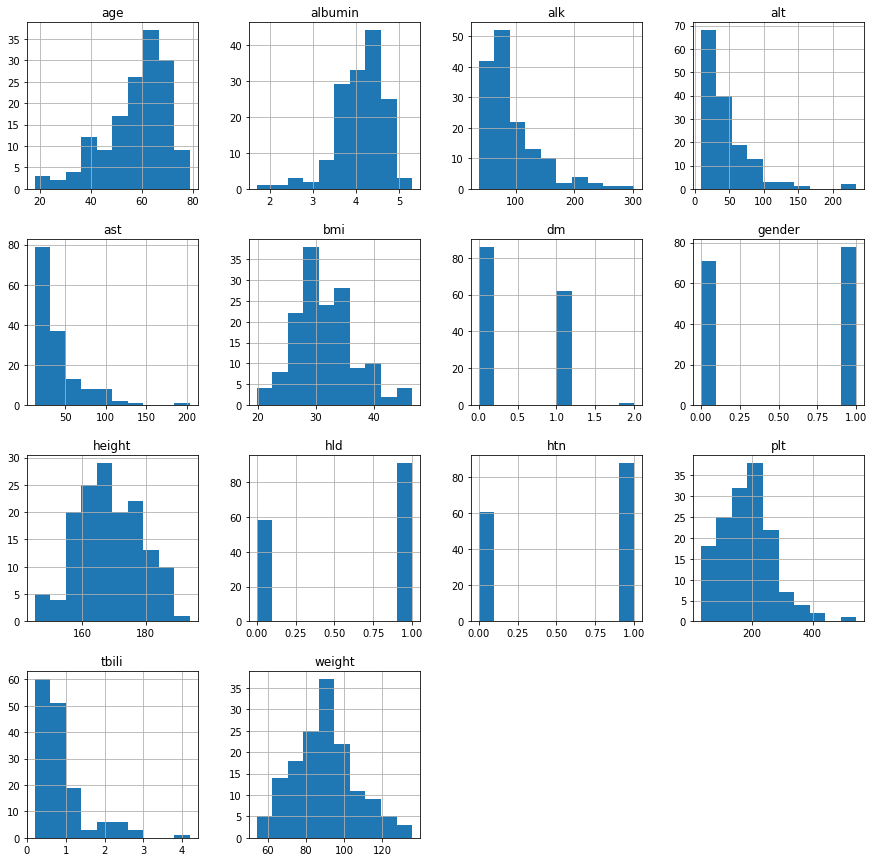

In [12]:
df_clinical.hist(figsize=(15,15))
plt.show()

In [59]:
df_all = pd.concat([df, df_clinical], axis=1).dropna()

In [60]:
print(df_all['baseline'].mean(), df_all['baseline'].std())

4330.060650953576 1375.6163603392313


## Bias Studies

In [61]:
df_all

mre     baseline  clinical_3best  age  gender  height  \
subject                                                                  
0006     3965.567046  4822.849158     4479.391738   54       0   165.0   
0020     3727.600644  3111.718841     3300.378546   64       0   185.0   
0029     3727.600644  2775.888614     3167.812636   70       1   179.0   
0043     3485.988186  3337.354326     3111.253707   29       1   167.0   
0126     5513.681652  5411.042367     6570.032605   46       0   176.0   
...              ...          ...             ...  ...     ...     ...   
2001     7220.789339  5314.141771     7177.766978   68       0   182.0   
2007     5780.700864  3678.465985     5397.145752   69       1   183.0   
2029     2261.857323  2721.936316     2243.401042   57       1   154.9   
2034     2623.089670  3686.193615     3514.206982   64       1   188.0   
2046     6641.576844  3085.449138     4468.736495   69       1   160.0   

         weight        bmi  htn  hld   dm   ast   alt    alk  tbili  albumin  \
subject                                                                        
0006       75.1  27.500000  0.0  1.0  0.0  29.0  93.0   70.0    0.6      4.3   
0020      101.0  29.500000  0.0  1.0  1.0  41.0  83.0   62.0    0.6      4.2   
0029      119.0  37.100000  1.0  1.0  1.0  47.0  92.0   92.0    2.4      4.1   
0043       76.2  27.100000  0.0  1.0  1.0  51.0  89.0  119.0    0.7      4.7   
0126      106.3  34.400000  1.0  1.0  1.0  41.0  78.0   58.0    0.9      4.3   
...         ...        ...  ...  ...  ...   ...   ...    ...    ...      ...   
2001       88.9  26.838546  1.0  1.0  1.0  95.0  73.0  237.0    1.4      2.5   
2007      113.4  33.861865  1.0  0.0  1.0  32.0  34.0   48.0    0.8      4.2   
2029       93.0  38.759674  0.0  1.0  1.0  31.0  24.0   48.0    0.9      4.3   
2034      113.0  31.971480  1.0  1.0  1.0  34.0  55.0   72.0    0.8      3.6   
2046       74.8  29.218750  0.0  0.0  1.0  28.0  17.0   78.0    2.2      3.6   

           plt  
subject         
0006     111.0  
0020     147.0  
0029      69.0  
0043     174.0  
0126     153.0  
...        ...  
2001      72.0  
2007     116.0  
2029     199.0  
2034     217.0  
2046     195.0  

[149 rows x 17 columns]

In [62]:
df_all['pulls'] = df_all['mre']-df_all['clinical_3best']
df_all['pulls'] = (df_all['pulls']-df_all['pulls'].mean())/df_all['pulls'].std()

In [63]:
df_all

mre     baseline  clinical_3best  age  gender  height  \
subject                                                                  
0006     3965.567046  4822.849158     4479.391738   54       0   165.0   
0020     3727.600644  3111.718841     3300.378546   64       0   185.0   
0029     3727.600644  2775.888614     3167.812636   70       1   179.0   
0043     3485.988186  3337.354326     3111.253707   29       1   167.0   
0126     5513.681652  5411.042367     6570.032605   46       0   176.0   
...              ...          ...             ...  ...     ...     ...   
2001     7220.789339  5314.141771     7177.766978   68       0   182.0   
2007     5780.700864  3678.465985     5397.145752   69       1   183.0   
2029     2261.857323  2721.936316     2243.401042   57       1   154.9   
2034     2623.089670  3686.193615     3514.206982   64       1   188.0   
2046     6641.576844  3085.449138     4468.736495   69       1   160.0   

         weight        bmi  htn  hld   dm   ast   alt    alk  tbili  albumin  \
subject                                                                        
0006       75.1  27.500000  0.0  1.0  0.0  29.0  93.0   70.0    0.6      4.3   
0020      101.0  29.500000  0.0  1.0  1.0  41.0  83.0   62.0    0.6      4.2   
0029      119.0  37.100000  1.0  1.0  1.0  47.0  92.0   92.0    2.4      4.1   
0043       76.2  27.100000  0.0  1.0  1.0  51.0  89.0  119.0    0.7      4.7   
0126      106.3  34.400000  1.0  1.0  1.0  41.0  78.0   58.0    0.9      4.3   
...         ...        ...  ...  ...  ...   ...   ...    ...    ...      ...   
2001       88.9  26.838546  1.0  1.0  1.0  95.0  73.0  237.0    1.4      2.5   
2007      113.4  33.861865  1.0  0.0  1.0  32.0  34.0   48.0    0.8      4.2   
2029       93.0  38.759674  0.0  1.0  1.0  31.0  24.0   48.0    0.9      4.3   
2034      113.0  31.971480  1.0  1.0  1.0  34.0  55.0   72.0    0.8      3.6   
2046       74.8  29.218750  0.0  0.0  1.0  28.0  17.0   78.0    2.2      3.6   

           plt     pulls  
subject                   
0006     111.0 -0.287878  
0020     147.0  0.476871  
0029      69.0  0.584602  
0043     174.0  0.434216  
0126     153.0 -0.728767  
...        ...       ...  
2001      72.0  0.164648  
2007     116.0  0.441385  
2029     199.0  0.144684  
2034     217.0 -0.594488  
2046     195.0  1.895462  

[149 rows x 18 columns]

In [64]:
df_all['pulls'].hvplot.hist(bins=100)

:Histogram   [pulls]   (pulls_count)

In [65]:
columns = df_all.columns
hist_list = []
for item in columns:
    if item != 'pulls':
        if df_all[item].nunique() == 2:
            hist_list.append(df_all.hvplot.hist(y='pulls', by=item, title=item, alpha=0.5, width=500))
        else:
            print(item)
            df_all[f'{item}_group'] = pd.cut(df_all[item], 3).astype(str)
            hist_list.append(df_all.hvplot.hist(y='pulls', by=f'{item}_group', title=item, alpha=0.5, width=500))

mre
baseline
clinical_3best
age
height
weight
bmi
dm
ast
alt
alk
tbili
albumin
plt


In [66]:
hv.Layout(hist_list).cols(3)

:Layout
   .NdOverlay.I    :NdOverlay   [mre_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.II   :NdOverlay   [baseline_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.III  :NdOverlay   [clinical_3best_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.IV   :NdOverlay   [age_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.V    :NdOverlay   [gender]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.VI   :NdOverlay   [height_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.VII  :NdOverlay   [weight_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.VIII :NdOverlay   [bmi_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.IX   :NdOverlay   [htn]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.X    :NdOverlay   [hld]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XI   :NdOverlay   [dm_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XII  :NdOverlay   [ast_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XIII :NdOverlay   [alt_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XIV  :NdOverlay   [alk_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XV   :NdOverlay   [tbili_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XVI  :NdOverlay   [albumin_group]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.XVII :NdOverlay   [plt_group]
      :Histogram   [pulls]   (pulls_count)

In [19]:
df_all['age_group'] = pd.cut(df_all['age'], 3).astype(str)

In [20]:
hist2 = df_all.hvplot.hist(y='pulls', by='age_group', title='age_group', alpha=0.5, bins=10)

In [21]:
hist1+hist2

:Layout
   .NdOverlay.I  :NdOverlay   [gender]
      :Histogram   [pulls]   (pulls_count)
   .NdOverlay.II :NdOverlay   [age_group]
      :Histogram   [pulls]   (pulls_count)

In [68]:
df_all['bmi_group'] = pd.cut(df_all['bmi'], 3).astype(str)

In [69]:
df_all.hvplot.hist(y='pulls', by='bmi_group', title='bmi_group', alpha=0.5, bins=10)

:NdOverlay   [bmi_group]
   :Histogram   [pulls]   (pulls_count)

In [4]:
%%capture --no-display
xr_viewer_models(ds_models, size=250, do_cor=True)

Column
    [0] WidgetBox(css_classes=['widget-box'])
        [0] Select(margin=(20, 20, 5, 20), name='mask_type', options=['liver', 'mre', 'combo'], value='liver', width=250)
        [1] Select(margin=(0, 20, 5, 20), name='subject', options=['0006', '0020', ...], value='0006', width=250)
        [2] DiscreteSlider(formatter='%d', margin=(5, 20, 20, 20), name='z', options=OrderedDict([('0', ...]), value=0, width=250)
        [3] FloatSlider(end=1, name='mask transparency', start=0, value=0.7)
        [4] RangeSlider(end=2000, name='contrast', step=1, value=(0, 1000))
        [5] RangeSlider(end=12000, name='mre contrast', step=1, value=(0, 10000))
    [1] HoloViews(Layout)

In [135]:
ds_models

<xarray.Dataset>
Dimensions:         (mask_type: 3, mre_type: 7, sequence: 9, subject: 167, x: 256, y: 256, z: 32, z_idx: 4)
Coordinates:
  * subject         (subject) object '0006' '0020' '0029' ... '2034' '2046'
  * sequence        (sequence) object 't1_pre_water' ... 't1_pos_300_water'
  * mask_type       (mask_type) object 'liver' 'mre' 'combo'
  * mre_type        (mre_type) <U11 'mre' 'mre_mask' ... 'three_nocon'
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * y               (y) int64 255 254 253 252 251 250 249 248 ... 6 5 4 3 2 1 0
  * z               (z) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: z_idx
Data variables:
    image_mri       (subject, sequence, x, y, z) int16 0 0 0 0 0 0 ... 0 0 0 0 0
    mask_mri        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    image_mre       (subject, mre_type, x, y, z) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_mre        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    mri_to_mre_idx  (subject, z_idx) int16 18 20 22 24 19 21 ... 20 16 18 20 22
    val_slope       (subject, mre_type) float64 1.0 1.0 1.0 ... 0.4889 0.4163
    val_intercept   (subject, mre_type) float64 0.0 0.0 ... 1.929e+03 2.149e+03

In [117]:
df_all.columns

Index(['mre', 'baseline', 'three_best', 'three_nocon', 'age', 'gender',
       'height', 'weight', 'bmi', 'htn', 'hld', 'dm', 'ast', 'alt', 'alk',
       'tbili', 'albumin', 'plt'],
      dtype='object')

In [ ]:
df_all

In [122]:
df_all[['baseline', 'age', 'gender',
       'height', 'weight', 'bmi', 'htn', 'hld', 'dm', 'ast', 'alt', 'alk',
       'tbili', 'albumin', 'plt']].iloc[0].values

array([4.35020419e+03, 5.40000000e+01, 0.00000000e+00, 1.65000000e+02,
       7.51000000e+01, 2.75000000e+01, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 2.90000000e+01, 9.30000000e+01, 7.00000000e+01,
       6.00000000e-01, 4.30000000e+00, 1.11000000e+02])

In [259]:
df_norm=df_all.copy()

In [260]:
#df_norm['mre'] = df_norm['mre']/5000
#df_norm['baseline'] = df_norm['baseline']/5000
print(df_norm['baseline'].mean(), df_norm['baseline'].std())
df_norm = (df_norm - df_norm.mean())/df_norm.std()

4139.379329404608 2410.923754949956


In [261]:
MREAvg(df_norm)[0]

(array([ 0.08744568, -0.31622035, -1.04461402, -0.30034099, -0.86303317,
        -0.78975503, -1.1970551 ,  0.79566641, -0.84204912, -0.39252521,
         1.35353458, -0.48383592, -0.45323275,  0.35490484, -0.88815716]),
 -0.10310664825198668)

In [262]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms

In [263]:
class MREAvg(Dataset):
    """MRE Subj Average Dataset"""

    def __init__(self, df):
        self.true_raw = df['mre']
        self.pred_raw = df[['baseline', 'age', 'gender',
       'height', 'weight', 'bmi', 'htn', 'hld', 'dm', 'ast', 'alt', 'alk',
       'tbili', 'albumin', 'plt']]

    def __len__(self):
        return len(self.true_raw)

    def __getitem__(self, idx):
        return self.pred_raw.iloc[idx].values, self.true_raw.iloc[idx]

In [264]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.sigmoid= torch.nn.Sigmoid()

    def forward(self, x):
        outputs = self.linear(x)
        outputs = self.sigmoid(outputs)
        return outputs
    
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [277]:
batch_size = 170
n_iters = 3000
epochs = n_iters / (len(df_norm['mre']) / batch_size)
input_dim = 15
output_dim = 1
lr_rate = 0.01

In [278]:
train_loader = torch.utils.data.DataLoader(dataset=MREAvg(df_norm), batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=MREAvg(df.iloc[:7]), batch_size=batch_size, shuffle=False)

In [279]:
model = LinearRegression(input_dim, output_dim)
criterion = torch.nn.MSELoss()

In [280]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [281]:
iter = 1
for epoch in range(int(epochs)):
    for i, (pred, true) in enumerate(train_loader):
        pred = Variable(pred.view(-1, input_dim)).float()
        true = Variable(true.view(-1,output_dim)).float()

        optimizer.zero_grad()
        outputs = model(pred)
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            predicted = outputs.data
            total = label.size(0)
            # for gpu, bring the predicted and label back to cpu fro python operations to work
            # accuracy = 100 * correct/total
            # print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
            print(f"Iteration: {iter}. Loss: {loss.item()}")
        loss = criterion(outputs, true)
        loss.backward()
        optimizer.step()

        iter+=1

Iteration: 500. Loss: 0.4128963351249695
Iteration: 1000. Loss: 0.4128012955188751
Iteration: 1500. Loss: 0.41280126571655273
Iteration: 2000. Loss: 0.41280126571655273
Iteration: 2500. Loss: 0.41280126571655273
Iteration: 3000. Loss: 0.41280126571655273


In [282]:
df_all['baseline_clinical'] = (predicted.numpy().flatten()*2410.923754949956+4139.379329404608)

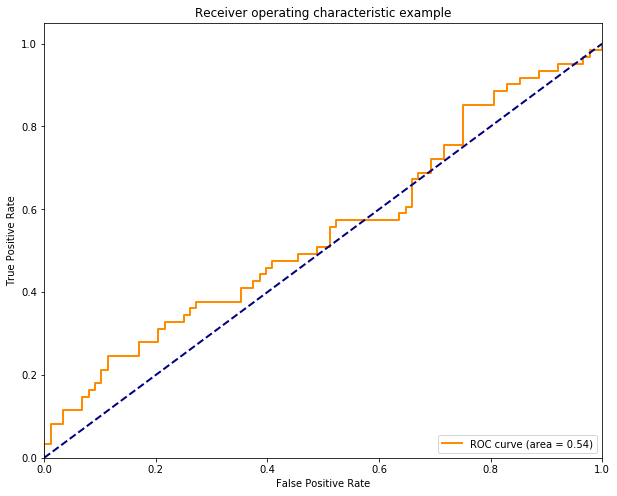

In [283]:
roc_curves(df_all, pred='baseline_clinical')

In [249]:
df_all

mre     baseline   three_best  three_nocon   age  gender  \
0006  3965.567046  4350.204193  6668.400059  3255.010268  54.0     0.0   
0020  3727.600644  2893.549916  4246.653734  1959.924095  64.0     0.0   
0029  3727.600644  2507.769980  3482.912455  3154.537398  70.0     1.0   
0043  3485.988186  2205.959151  1790.979210  2170.804756  29.0     1.0   
0126  5513.681652  4900.534710  5298.847538  2986.610746  46.0     0.0   
...           ...          ...          ...          ...   ...     ...   
2001  7220.789339  7123.671660  7129.332314  8445.597393  68.0     0.0   
2007  5780.700864  6122.839494  6372.503353  6410.712352  69.0     1.0   
2029  2261.857323  1789.690960  2262.318817  1149.710126  57.0     1.0   
2034  2623.089670  2356.081476  2279.336583  1915.474889  64.0     1.0   
2046  6641.576844  2628.656934  4157.248733  4329.734386  69.0     1.0   

      height  weight        bmi  htn  hld   dm   ast   alt    alk  tbili  \
0006   165.0    75.1  27.500000  0.0  1.0  0.0  29.0  93.0   70.0    0.6   
0020   185.0   101.0  29.500000  0.0  1.0  1.0  41.0  83.0   62.0    0.6   
0029   179.0   119.0  37.100000  1.0  1.0  1.0  47.0  92.0   92.0    2.4   
0043   167.0    76.2  27.100000  0.0  1.0  1.0  51.0  89.0  119.0    0.7   
0126   176.0   106.3  34.400000  1.0  1.0  1.0  41.0  78.0   58.0    0.9   
...      ...     ...        ...  ...  ...  ...   ...   ...    ...    ...   
2001   182.0    88.9  26.838546  1.0  1.0  1.0  95.0  73.0  237.0    1.4   
2007   183.0   113.4  33.861865  1.0  0.0  1.0  32.0  34.0   48.0    0.8   
2029   154.9    93.0  38.759674  0.0  1.0  1.0  31.0  24.0   48.0    0.9   
2034   188.0   113.0  31.971480  1.0  1.0  1.0  34.0  55.0   72.0    0.8   
2046   160.0    74.8  29.218750  0.0  0.0  1.0  28.0  17.0   78.0    2.2   

      albumin    plt  baseline_clinical  
0006      4.3  111.0        3703.953613  
0020      4.2  147.0        3353.203125  
0029      4.1   69.0        6391.303711  
0043      4.7  174.0        3700.932373  
0126      4.3  153.0        6553.707031  
...       ...    ...                ...  
2001      2.5   72.0        3277.960449  
2007      4.2  116.0        5742.130371  
2029      4.3  199.0        5296.719238  
2034      3.6  217.0        2907.163574  
2046      3.6  195.0        4235.780273  

[149 rows x 19 columns]